In [113]:
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import jax.numpy as jnp
import arviz as az
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [114]:
data = pd.read_csv('../../data/panel_data.csv')

data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['cases'] = data['cases'].astype(int)

data = data.sort_values(by=['state', 'time'])  # Ensure data is sorted
data['lag_cases'] = data.groupby('state')['cases'].shift(1)
data = data.dropna(subset=['lag_cases'])
data = pd.get_dummies(data, columns=['state', 'month'], drop_first=False)
states = [element.split('_')[1] for element in data.columns if element.startswith('state')]
data.head()

,time,t2m,tp,lai_hv,lai_lv,cases,deaths,year,lag_cases,state_BAHR EL GAZEL,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
33,2020-02-01,21.966063,0.001508,0.018410,0.666643,165,0.0,2020,259.0,True,...,False,False,False,False,False,False,False,False,False,False
56,2020-03-01,29.094683,0.000762,0.018419,0.672094,112,0.0,2020,165.0,True,...,True,False,False,False,False,False,False,False,False,False
79,2020-04-01,32.909817,0.000761,0.018420,0.674704,160,1.0,2020,112.0,True,...,False,True,False,False,False,False,False,False,False,False
102,2020-05-01,34.160160,0.006172,0.018420,0.676452,127,0.0,2020,160.0,True,...,False,False,True,False,False,False,False,False,False,False
125,2020-06-01,34.258059,0.059696,0.018422,0.686095,83,0.0,2020,127.0,True,...,False,False,False,True,False,False,False,False,False,False


In [115]:
data_test = data[data['time']>'2023-06-01']
X_test = jnp.array(data_test[['lag_cases','t2m', 'tp'] + [col for col in data_test.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
y_test = jnp.array(data_test['cases'].values.astype(int).tolist())

In [116]:
data_train = data[data['time']<='2023-06-01']
X_train = jnp.array(data_train[['lag_cases','t2m', 'tp'] + [col for col in data_train.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
y_train = jnp.array(data_train['cases'].values.astype(int).tolist())

In [117]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp

def panel_model(X, y=None):
    # Priors for coefficients of continuous variables
    beta_t2m = numpyro.sample('beta_t2m', dist.Normal(25, 5.0))
    beta_tp = numpyro.sample('beta_tp', dist.Normal(0, 1.0))
    beta_state = numpyro.sample('beta_state', dist.Normal(100, 10.0).expand([23]))
    beta_month = numpyro.sample('beta_month', dist.Normal(0, 0.5).expand([12]))
    beta_lag = numpyro.sample('beta_lag', dist.Normal(0, 1.0))

    mu_lag = jnp.dot(X[:, 0], beta_lag)
    mu_t2m = jnp.dot(X[:, 1], beta_t2m)
    mu_tp = jnp.dot(X[:, 2], beta_tp)
    mu_state = jnp.dot(X[:, 3:26], beta_state)
    mu_month = jnp.dot(X[:, 26:], beta_month)
    
    # sigma = numpyro.sample('sigma', dist.HalfNormal(1.0))
    mu = numpyro.deterministic('mu', mu_t2m + mu_tp + mu_lag + mu_state + mu_month)
    numpyro.sample('obs', dist.Poisson(jnp.abs(mu)), obs=y)
    # numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)
    
# Run MCMC to sample from the posterior
nuts_kernel = NUTS(panel_model)
mcmc = MCMC(nuts_kernel, num_samples=10_000, num_warmup=5_000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, X=X_train, y=y_train)

# Summarize the results
mcmc.print_summary()

sample: 100%|██████████| 15000/15000 [01:15<00:00, 199.38it/s, 15 steps of size 2.41e-01. acc. prob=0.92]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_lag      0.88      0.00      0.88      0.88      0.88   8568.54      1.00
 beta_month[0]     -0.89      0.47     -0.89     -1.68     -0.13  14672.92      1.00
 beta_month[1]     -2.45      0.48     -2.45     -3.20     -1.61  15184.12      1.00
 beta_month[2]     -0.44      0.48     -0.44     -1.24      0.33  13896.52      1.00
 beta_month[3]     -2.69      0.49     -2.68     -3.49     -1.87  16907.06      1.00
 beta_month[4]     -2.30      0.49     -2.30     -3.13     -1.53  14629.22      1.00
 beta_month[5]      0.67      0.49      0.67     -0.13      1.47  15803.64      1.00
 beta_month[6]      7.61      0.49      7.62      6.84      8.46  16084.22      1.00
 beta_month[7]      2.87      0.50      2.87      2.05      3.68  16172.47      1.00
 beta_month[8]      4.51      0.49      4.51      3.69      5.32  15859.52      1.00
 beta_month[9]      0.64      0.49      0.64     -0.15      1.47

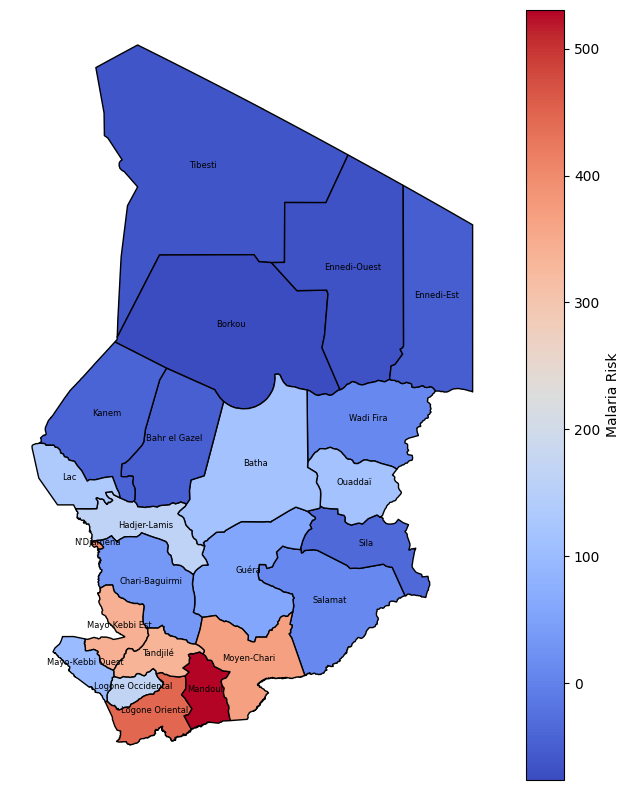

In [118]:
import cartopy.crs as ccrs
import geopandas as gpd

samples = mcmc.get_samples()
map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data.loc[21, 'shapeName'] = "N'Djamena"
shape_names = map_data['shapeName'].tolist()
shape_names.sort()
map_data['risk'] = [None]*23
for element in shape_names:
    map_data.loc[map_data['shapeName']==element, 'risk'] = samples['beta_state'][:, shape_names.index(element)].mean()
map_data['risk'] = pd.to_numeric(map_data['risk'], errors='coerce')

map_data = map_data.to_crs(epsg=3857) 

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# ax = plt.axes(projection=ccrs.PlateCarree())
map_data.plot(edgecolor='black', column='risk', cmap='coolwarm', ax=ax, legend=True,
              legend_kwds={'label': "Malaria Risk", 'orientation': "vertical"})
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['shapeName']):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center')
plt.axis('off')

plt.savefig('../../docs/risk-scores.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

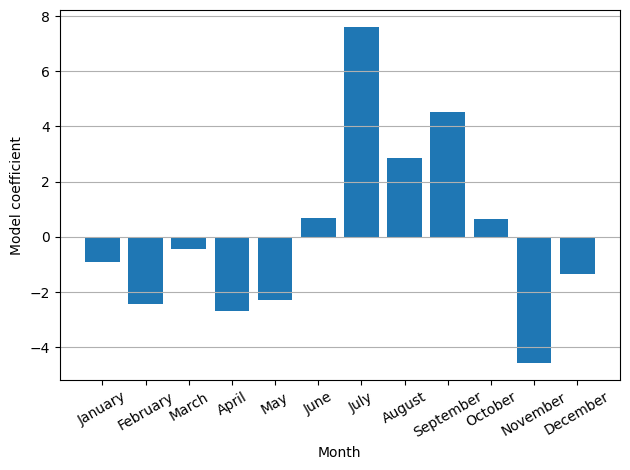

In [119]:
import matplotlib.pyplot as plt

# Corrected months list
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting the mean of 'beta_month' across the samples
plt.bar(months, samples['beta_month'].mean(axis=0))

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Model coefficient')
# plt.title('Mean beta_month Coefficients by Month')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=30)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('../../docs/monthly-risk.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

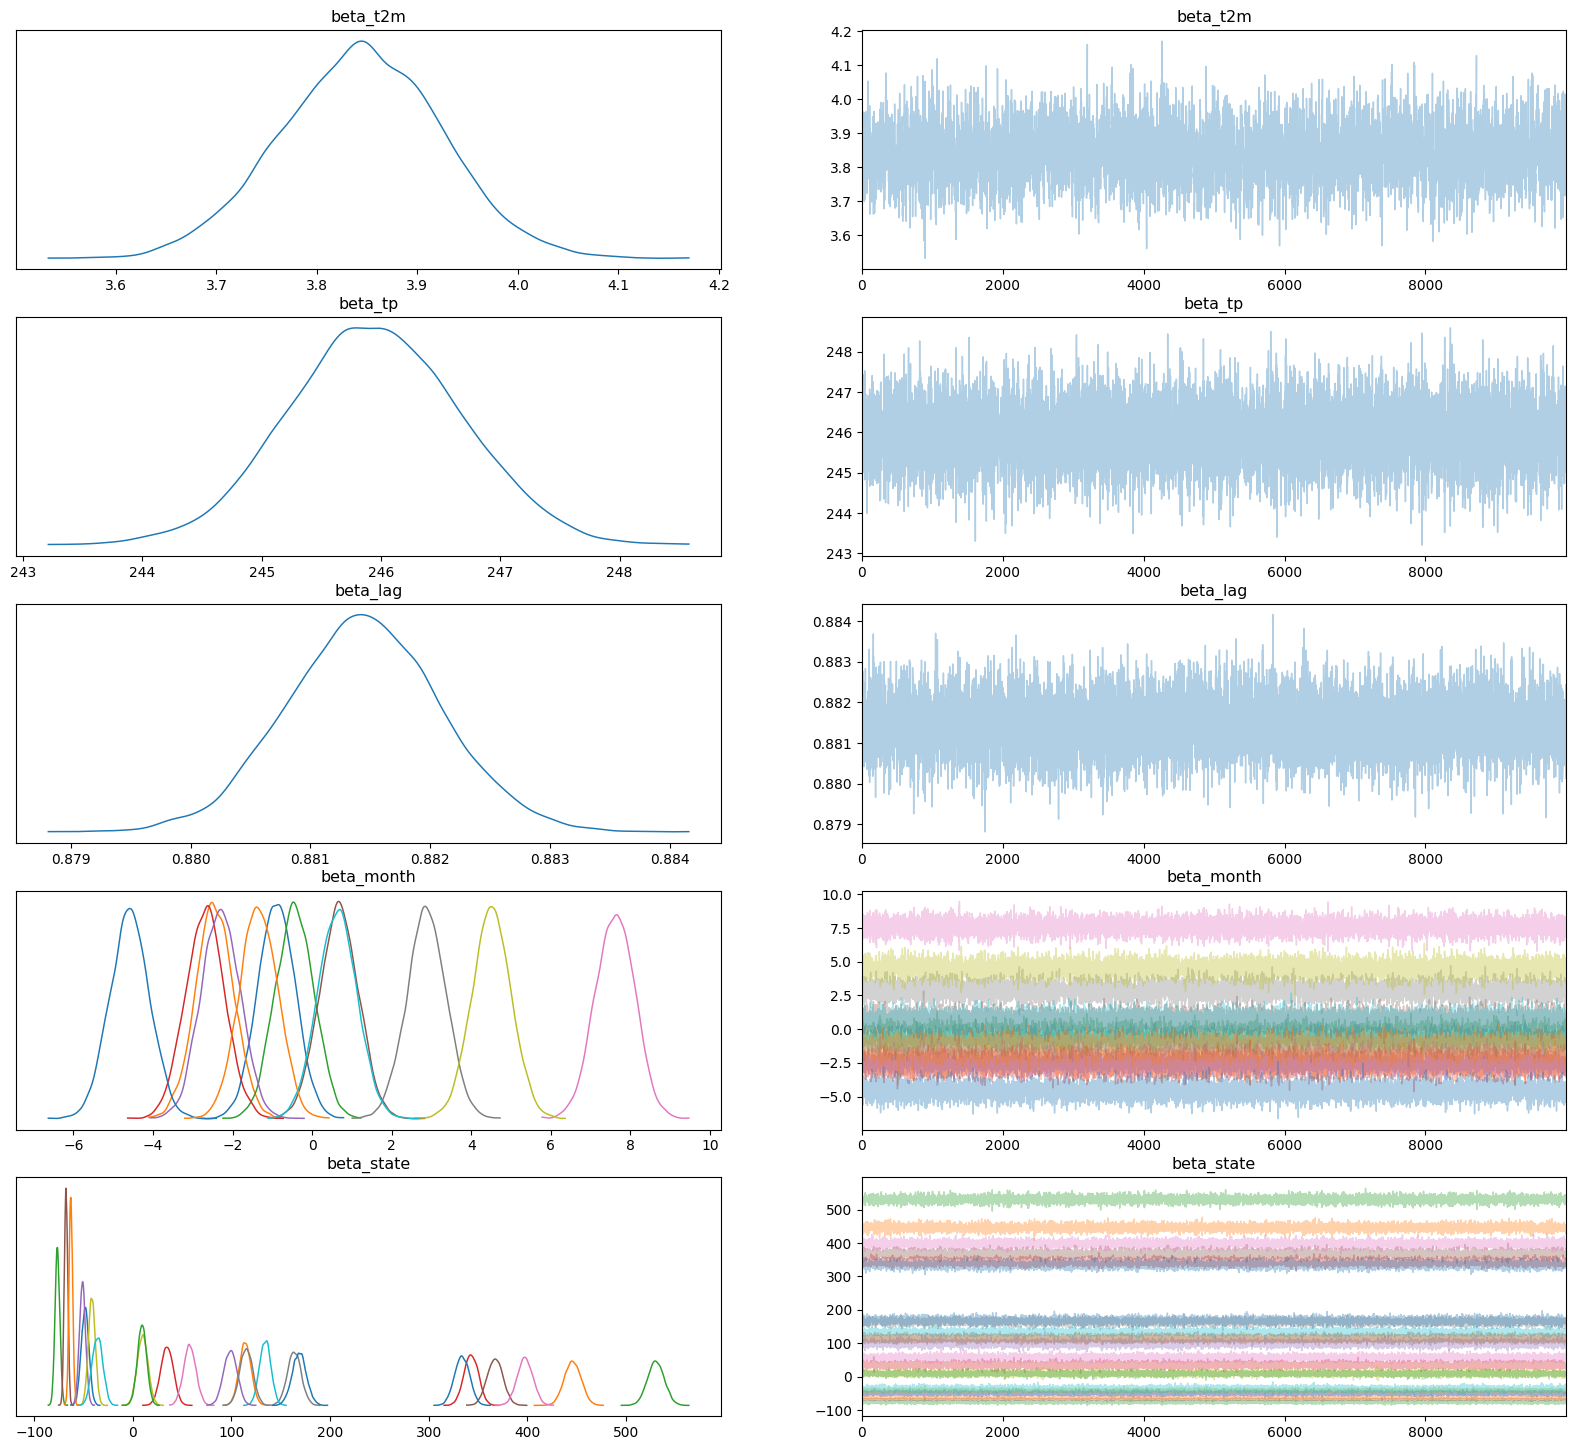

In [120]:
idata = az.from_numpyro(mcmc)
az.rcParams['plot.max_subplots'] = 200
az.plot_trace(idata, compact=True, figsize=(20,18), kind='trace', var_names=["beta_t2m", 'beta_tp', 'beta_lag','beta_month', 'beta_state'])
plt.savefig('../../docs/trace_plot.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Calculate WAIC and LOO-CV

In [31]:
waic = az.waic(idata)
loo = az.loo(idata)

print('WAIC:', waic)
print('LOO-CV:', loo)

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC: Computed from 10000 posterior samples and 943 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -268934.18  28314.02
p_waic     7360.81        -

There has been a warning during the calculation. Please check the results.
LOO-CV: Computed from 10000 posterior samples and 943 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -266667.39  27712.91
p_loo     5094.03        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      703   74.5%
   (0.70, 1]   (bad)        92    9.8%
   (1, Inf)   (very bad)  148   15.7%



/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


## Pred vs. original

In [129]:
def predict(X, model, key):
    _, rng_key_ = random.split(key)
    samples_1 = model.get_samples()
    predictive = Predictive(panel_model, samples_1)
    posterior_predictions = predictive(rng_key_, X=X)
    post_obs = posterior_predictions['mu']
    mean_post_pred = jnp.mean(post_obs, axis=0)
    CI_inf = jnp.quantile(post_obs, q=0.05, axis=0)
    CI_sup = jnp.quantile(post_obs, q=0.95, axis=0)
    
    return mean_post_pred, CI_inf, CI_sup

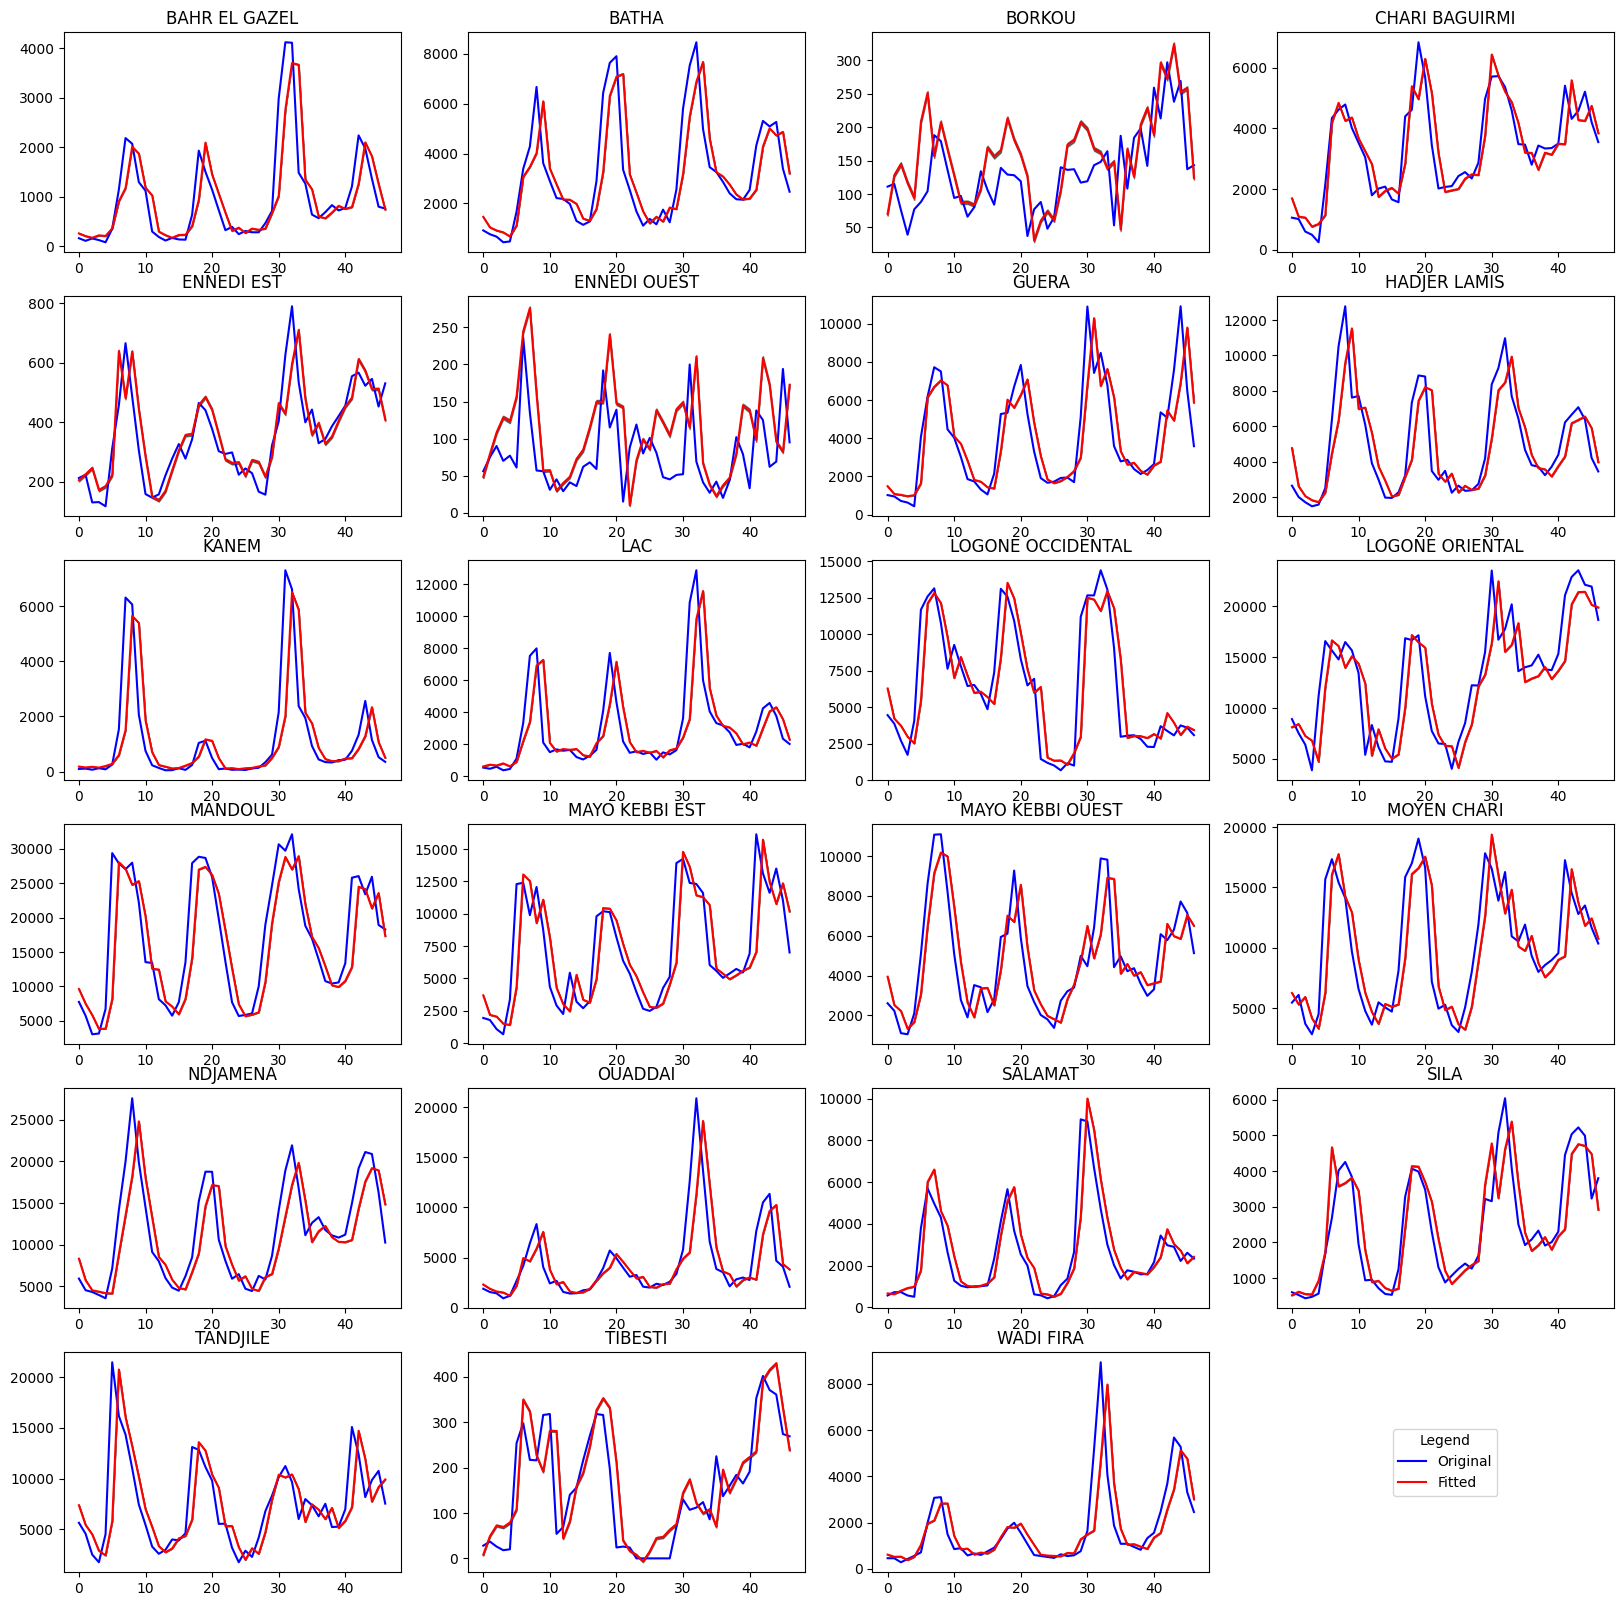

In [131]:
X = jnp.array(data[['lag_cases','t2m', 'tp'] + [col for col in data.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
y = jnp.array(data['cases'].values.astype(int).tolist())

fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred, inf_, sup_ = predict(X[X[:,3+i]==1], mcmc, rng_key)
    axes[idx,idy].plot(y[X[:,3+i]==1], label='Original', color='blue')
    axes[idx,idy].plot(mean_post_pred, label='Fitted', color='red')
    axes[idx,idy].fill_between(xticks, inf_, sup_, color='black', alpha=0.5)
    axes[idx,idy].set_title(states[i])

axes[5, 3].clear()
axes[5, 3].axis('off')
handles, labels = axes[0, 0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[5, 3].transAxes, title='Legend')

plt.savefig('../../docs/predictions.png', bbox_inches='tight', pad_inches=0.1)

## Residuals plot

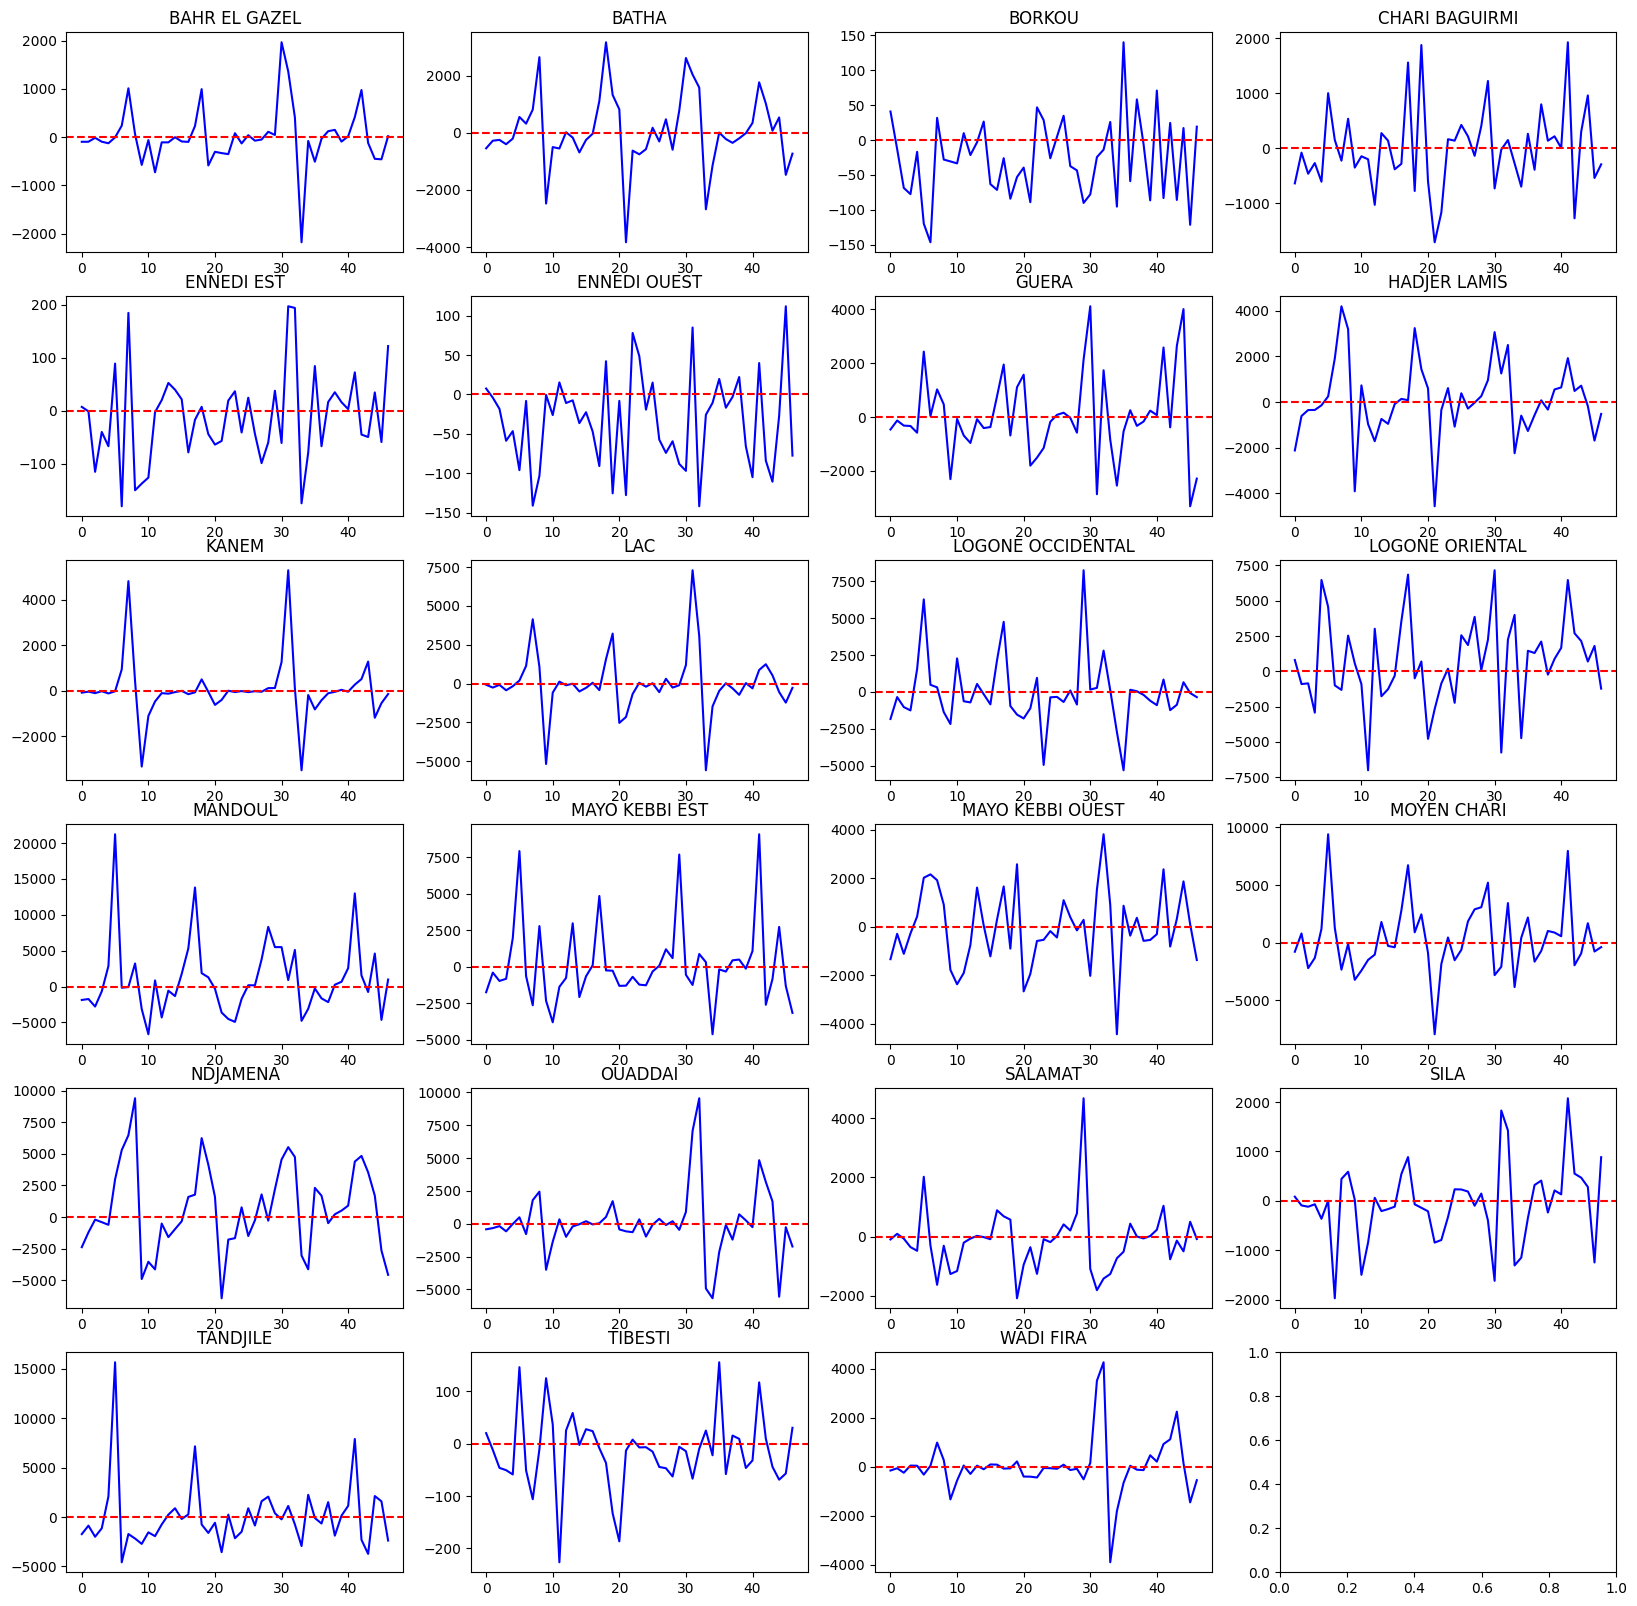

In [124]:
fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred, _, _ = predict(X[X[:,3+i]==1], mcmc, rng_key)
    axes[idx,idy].plot(y[X[:,3+i]==1]-mean_post_pred, label='Original', color='blue')
    axes[idx,idy].axhline(0, color='red', linestyle='--')
    axes[idx,idy].set_title(states[i])

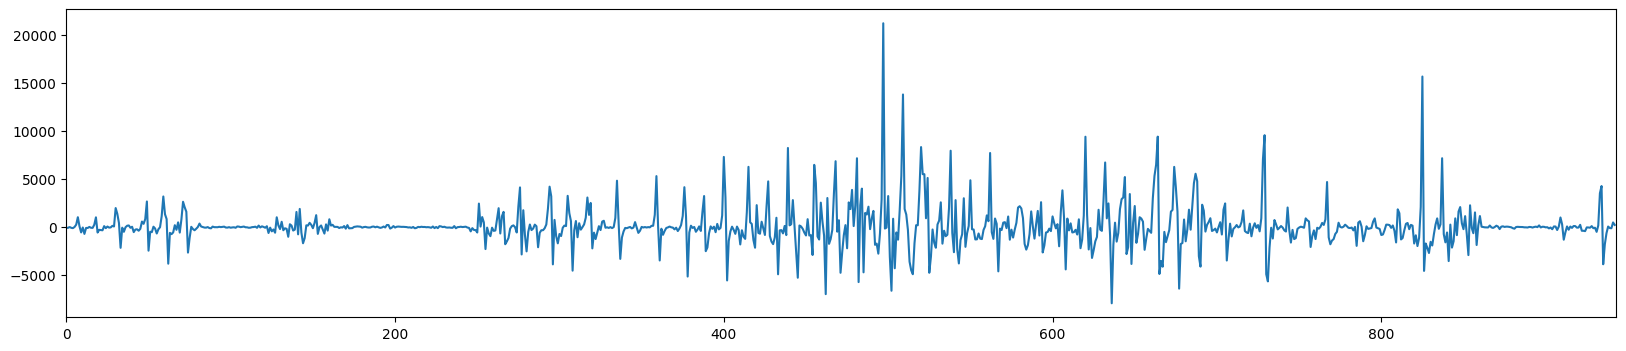

In [127]:
pred_mean, _,_ = predict(X_train, mcmc, rng_key)

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(y_train-pred_mean)
plt.savefig('../../docs/residual_train.png', bbox_inches='tight', pad_inches=0.1)
plt.xlim((0,len(pred_mean)))
plt.show()

## Evaluation metrics

In [135]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
samples_1 = mcmc.get_samples()
predictive = Predictive(panel_model, samples_1)
posterior_predictions = predictive(rng_key_, X=X_test)
post_obs = posterior_predictions['obs']

mean_post_pred = round(jnp.mean(post_obs, axis=0))
hpdi_post_pred = hpdi(post_obs, 0.9)

In [136]:
rmse = jnp.sqrt(((y_test - mean_post_pred)**2).mean())
mae = jnp.abs(y_test - mean_post_pred).mean()

ss_total = jnp.var(y_test)
ss_residual = jnp.mean((y_test - mean_post_pred.round()) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print('RMSE:', rmse)
print('MAE:', mae)
print(f'Bayesian R-squared: {r_squared}')

RMSE: 2434.3982
MAE: 1471.7174
Bayesian R-squared: 0.8699630498886108
